# GRADTDA5622 - Big Data Computing Foundations II  
### **CRISP-DM: Data Preparation**  
#### Developing a clean dataset for analysis and/or modeling

This notebook will serve as complementary to the detail provided by Dr. Bihari during the asynchronous Data Preparation walk through. Additional methods are demonstrated in an attempt to consider a scenario where data will eventually be regularly received and scored by a deployed predictive model (i.e., automated ETL pipeline). Additionally, we'll quickly consider a commonly used method for identifying and representing viable data to a predictive model.

Helpful resources:  
* [Data Drift](https://www.nannyml.com/blog/types-of-data-shift)  
* [Dataset Transformations](https://scikit-learn.org/stable/data_transforms.html)
* [Feature Importance](https://www.geeksforgeeks.org/feature-selection-techniques-in-machine-learning/)

---  
### Retrieve the dataset from Github  
Systematically ingest data from an established source repository. It can be important to use Python objects or environment varibles to name file locations and other settings. These settings often change and your goal, as an engineer, is to write your applications in a manner which is easily comprehended and requires the least amount of maintenance. This is especially true if there is a cost associated with testing and redeploying the Python application in a production environment.

In [1]:
import pandas as pd

# Establish the URL root
str_url = 'https://bcoy48.github.io/osu-gradtda-5622-sp25/course_materials/sync_class/'

# Establish a file name, if not consuming from a production location
str_file = 'teb_enhanced_iris_dataset_v2.xlsx'
str_sheet = 'enhanced1_copy_with_errors'

# Retrieve the data (dynamically)
df_orig = pd.read_excel(str_url + str_file, sheet_name=str_sheet)

# Print an overview of the dataset
print(df_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   row_id           152 non-null    int64  
 1   sepal_length     152 non-null    float64
 2   sepal_width      152 non-null    float64
 3   petal_length     152 non-null    float64
 4   petal_width      152 non-null    float64
 5   species          151 non-null    object 
 6   sepal_area       151 non-null    float64
 7   sepal_shape_val  152 non-null    float64
 8   sepal_shape      151 non-null    object 
 9   petal_area       152 non-null    float64
 10  petal_shape_val  152 non-null    float64
 11  petal_shape      152 non-null    object 
 12  color            152 non-null    object 
 13  zone             152 non-null    int64  
dtypes: float64(8), int64(2), object(4)
memory usage: 16.8+ KB
None


---
### Remove fully duplicative rows  
As a first step, let's assume that fully duplicative rows are a byproduct of poor data management.

In [2]:
# Remove the duplicate row and begin operating on a copy of the dataset
df_clean = df_orig.drop_duplicates()

print(df_clean.shape)

(151, 14)


---
### Systematically correct spelling errors in categorical fields  
Predictive models are often built with the goal of utilizing a trained model to regular generate insights in a production setting. Manually correcting spelling mistakes in categorical strings may not be cumbersome now, but it's probably untenable to manually correct spelling mistakes every time the trained model is used. The following demonstration illustrates how fuzzy string matching to an expected set of values offers a more automated option. Various fuzzy string matching methods are available for use. It is important to select and test the method which is appropriate to your situation (e.g., spelling correction may be different for common English phrases compared to human names). The goal is to develop a reliable and consistent solution. Additionally, it is common to log potential errors or uncertainties experienced during production use.

In [3]:
# Review the misspelled species strings
df_clean.species.value_counts(dropna=False)

,count
species,
versicolor,50
virginica,50
setosa,49
setos,1
NaN,1


In [4]:
# Helpful resources:
# https://rapidfuzz.github.io/RapidFuzz/index.html
# https://en.wikipedia.org/wiki/Edit_distance

%pip install rapidfuzz==3.12.2
import rapidfuzz

from operator import itemgetter

# Establish an expected set of 'species' strings
# * Typically reference lists, like this, would be externalized in a Github repo
#   so that the main application code doesn't need to be altered in the event that
#   a new value is expected or a change needs made (being sure to test changes)
list_species = ['versicolor', 'virginica', 'setosa']

# Establish an empty list to write unacceptable data errors to
list_species_errors = []

# Establish a function to identify spelling errors and correct accordingly
def categorical_string_correction(str_orig, float_threshold=0.9, list_expected=list_species, list_errors=list_species_errors):
  """
  Params:
    - str_orig: this is the string as it is originally observed in the dataset
    - list_expected: this is the list of expected values for a particular feature
  """

  try:
    # Return the original string if it is correct as-is
    if str_orig in list_expected:
      return str_orig

    else:
      # Clean the string in a standardized manner (e.g., remove extra whitespace and lowercase)
      str_clean = str_orig.strip().lower()

      # Search for a potential match to correct the misspelled string to
      list_possible = [(str_option, rapidfuzz.distance.JaroWinkler.similarity(str_clean, str_option)) for str_option in list_expected]
      tuple_best = max(list_possible, key=itemgetter(1))

      # Conditionally return the possible string correction based on the match threshold
      if tuple_best[1] >= float_threshold:
        return tuple_best[0]

      # Log the incorrect string for further investigation and set the incorrect string to null
      else:
        list_errors.append({str_orig: tuple_best})
        return None

  except Exception as e:
    raise e

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.4 MB/s eta 0:00:00


In [5]:
# Test the example found in the datset
print(f'Replaced: {categorical_string_correction("setos")} or Error: {list_species_errors}')

Replaced: setosa or Error: []


In [6]:
# Test an example which should never be corrected
print(f'Replaced: {categorical_string_correction("v")} or Error: {list_species_errors}')

Replaced: None or Error: [{'v': ('virginica', 0.7333333333333334)}]


In [7]:
# Execute this method at the scale of the full dataset, only executing when necessary
df_clean.loc[(~df_clean.species.isin(list_species) & ~df_clean.species.isnull()), 'species'] = df_clean.loc[(~df_clean.species.isin(list_species) & ~df_clean.species.isnull()), 'species'].apply(categorical_string_correction)

# Review the effect of this cleaning method
print(df_clean.loc[8, :])

row_id                     8
sepal_length             4.4
sepal_width              2.9
petal_length             1.4
petal_width              0.2
species               setosa
sepal_area             12.76
sepal_shape_val     1.517241
sepal_shape           square
petal_area              0.28
petal_shape_val          7.0
petal_shape        very_long
color                purple 
zone                       3
Name: 8, dtype: object


---
### Identify issues within computed values  
Utilizing data which describes the physical world can be advantageous to analysts and engineers because there is an understood reality to what the data represents. For example, sepals and petals are regularly observed and studied, so we should know what the smallest and largest observation of an Iris flower has ever been. This information makes it easier to layer data quality limits into an automated application. The following demonstration builds upon the methods Dr. Bihari covered in the asynchronous material (e.g., visually pinpointing outliers) by systematically flagging bad data. What we do with the data quality flags is likely a contextual consideration, but here, we will remove bad data and recalculate dependent features.

<Axes: >

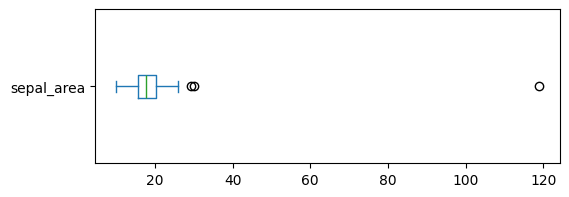

In [8]:
# Review the distribution of sepal_area values
df_clean.sepal_area.plot.box(vert=False, figsize=(6, 2))

In [9]:
# Review the invalid value identified visually
df_clean[(df_clean.sepal_area > 40)]

,row_id,sepal_length,sepal_width,petal_length,petal_width,species,sepal_area,sepal_shape_val,sepal_shape,petal_area,petal_shape_val,petal_shape,color,zone
21,21,5.1,3.7,1.5,0.4,setosa,118.87,1.378378,square,0.6,3.75,oblong,purple,6


In [10]:
# References:
# https://en.wikipedia.org/wiki/Iris_setosa
# https://en.wikipedia.org/wiki/Iris_virginica
# https://en.wikipedia.org/wiki/Iris_versicolor

# Establish min/max values for the dependent columns based on Iris information sources
# List holds [length:(min, max), width:(min, max)]
list_sepal_size = [(4.3, 7.9), (2.0, 4.4)]

# Select any rows where the sepal length or width exceeds the known min/max
df_sepal_size_check = df_clean[
    (
        (df_clean.sepal_length < list_sepal_size[0][0]) |
         (df_clean.sepal_length > list_sepal_size[0][1]) |
          (df_clean.sepal_width < list_sepal_size[1][0]) |
           (df_clean.sepal_width > list_sepal_size[1][1])
     )
]

# Obtain the dataframe indices of any length and/or width values which exceed expectations
print(df_sepal_size_check.index)

Index([], dtype='int64')


In [11]:
# No length or width values are flagged as errors, now will check the area results
df_sepal_area_check = df_clean[
    (
        df_clean.sepal_area != (df_clean.sepal_length * df_clean.sepal_width)
    )
]

# Obtain the dataframe indices of any length and/or width values which exceed expectations
print(df_sepal_area_check.index)

Index([21, 123, 150], dtype='int64')


In [12]:
# Review the incorrect sepal_area values
df_sepal_area_check

,row_id,sepal_length,sepal_width,petal_length,petal_width,species,sepal_area,sepal_shape_val,sepal_shape,petal_area,petal_shape_val,petal_shape,color,zone
21,21,5.1,3.7,1.5,0.4,setosa,118.87,1.378378,square,0.60,3.750000,oblong,purple,6
123,122,7.7,2.8,6.7,2.0,virginica,NaN,2.750000,oblong,13.40,3.350000,oblong,white,7
150,149,4.9,3.0,5.1,1.8,virginica,17.70,1.966667,square,9.18,2.833333,square,pink,9


In [13]:
# Replace invalid sepal_area values in the main dataframe as efficiently as possible,
# With the understanding that the sepal length and width values are within normal physical limits.
# However, could these rows also be dropped as including comparably dubious measurement data?
df_clean.loc[df_sepal_area_check.index, 'sepal_area'] = df_clean.loc[df_sepal_area_check.index, 'sepal_length'] * df_clean.loc[df_sepal_area_check.index, 'sepal_width']

# Review the effects of the data correction
df_clean.loc[(df_sepal_area_check.index), :]

,row_id,sepal_length,sepal_width,petal_length,petal_width,species,sepal_area,sepal_shape_val,sepal_shape,petal_area,petal_shape_val,petal_shape,color,zone
21,21,5.1,3.7,1.5,0.4,setosa,18.87,1.378378,square,0.60,3.750000,oblong,purple,6
123,122,7.7,2.8,6.7,2.0,virginica,21.56,2.750000,oblong,13.40,3.350000,oblong,white,7
150,149,4.9,3.0,5.1,1.8,virginica,14.70,1.966667,square,9.18,2.833333,square,pink,9


---
### Detecting data drift  
Often times predictive models are trained and tested one time with, hopefully, a sample of data that represents the population the model will be applied to once it is deployed into production. As long as the data representation of these embedded assumptions don't materially change over time then we should expect the deployed model to continue performing within expectations. However, knowledge and context can change with time. The following demonstration attempts to highlight one way in which the feature data can be systematically monitered upstream of the deployed model. It's often best to flag changes in data distributions before a production model generates a consumable insight. Proper alerting and logging design is also imperative to effectively maintaining trust in a deployed analytic pipeline.

Skewness: 0.51, Kurtosis: 0.93


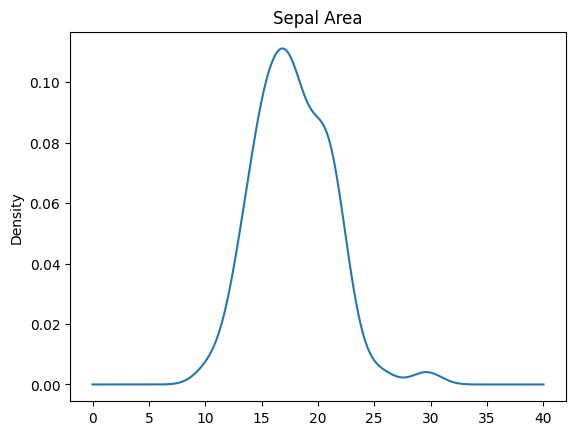

In [14]:
# References:
# https://www.smartpls.com/documentation/functionalities/excess-kurtosis-and-skewness

# Review the distribution of the data - Visual
df_clean.sepal_area.plot.kde(title='Sepal Area')

# Review the distribution of the data - Text Rerference
print(f'Skewness: {df_clean.sepal_area.skew():.2f}, Kurtosis: {df_clean.sepal_area.kurtosis():.2f}')

In [16]:
# References:
# https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
# https://numpy.org/devdocs/reference/generated/numpy.histogram.html
# https://numpy.org/devdocs/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges

import numpy as np

# Since the reference data is normally distributed, we'll prepare bins by first
# calculating the number of bins via "Scott's normal reference rule"
_, bin_edges = np.histogram(df_clean.sepal_area, bins='scott')

# The data is slightly right tailed because of the values greater than 24.
# We will condense those higher value bins into 1 bin to avoid bins with 0
# observations (typically would make the reference value callable from external).
# Time permitting, we would find an alternative to hard coding the upper bound.
bin_edges = list(filter(lambda x: x <= 26.016, bin_edges))

# Use Pandas 'cut' function to embed the bin values in the dataframe
df_clean['sepal_area_bins'] = pd.cut(df_clean.sepal_area, bin_edges)

# Review the results
df_clean['sepal_area_bins'].value_counts(sort=False)

,count
sepal_area_bins,
"(10.0, 12.002]",3
"(12.002, 14.004]",13
"(14.004, 16.006]",33
"(16.006, 18.008]",37
"(18.008, 20.01]",23
"(20.01, 22.012]",28
"(22.012, 24.014]",9
"(24.014, 26.016]",2


In [17]:
# References:
# https://www.nannyml.com/blog/population-stability-index-psi

# Establish a popualtion stability function, utilizing the previously prepared bin definitions
def psi(monitored, reference, bins=bin_edges):

    # Calculate the histogram for each dataset
    reference_hist, _ = np.histogram(reference, bins=bins)
    monitored_hist, _ = np.histogram(monitored, bins=bins)

    # Convert histograms to proportions
    reference_proportions = reference_hist / np.sum(reference_hist)
    monitored_proportions = monitored_hist / np.sum(monitored_hist)

    # Replace zeroes to avoid division by zero or log of zero errors
    monitored_proportions = np.where(monitored_proportions == 0, 1e-6, monitored_proportions)
    reference_proportions = np.where(reference_proportions == 0, 1e-6, reference_proportions)

    # Calculate PSI
    psi_values = (monitored_proportions - reference_proportions) * np.log(monitored_proportions / reference_proportions)
    psi = np.sum(psi_values)

    return psi

In [18]:
# %pip install random
import random

# Establish the reference data as an array
reference_observations = df_clean.sepal_area.values

# Generate 150 random numbers to synthetically represent "monitored" sepal_area data
# ** Notice the created data ranges between the known min and max sepal area
np.random.seed(42)
monitored_observations = np.random.uniform((4.3*2.0), (7.9*4.4), size=(150,))

# Calculate PSI and store the result
# example_psi = psi(reference_observations, reference_observations)
example_psi = psi(monitored_observations, reference_observations)

# Review the result
if example_psi >= 0.25:
  print(f'Significant drift detected, see PSI: {example_psi:.4f}')
elif example_psi >= 0.10:
  print(f'Moderate drift detected, see PSI: {example_psi:.4f}')
else:
  print(f'No noteworth population change, see PSI: {example_psi:.4f}')

Significant drift detected, see PSI: 0.6956


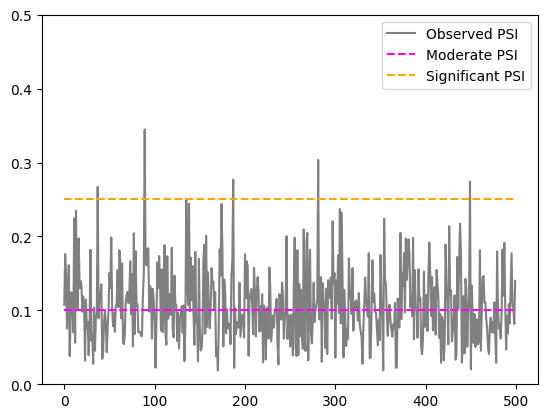

In [24]:
import matplotlib.pyplot as plt

# Establish an empty list to write data to
list_viz_data = []

# Establish normal distribution reference values
sepal_area_mu = df_clean.sepal_area.mean()
sepal_area_sigma = df_clean.sepal_area.std()

# Randomly generate 500 PSI values to subsequently visualize
for x in range(500):

  # Generate the synthetic, random data following a normal distribution
  monitored_observations = np.random.normal(sepal_area_mu, sepal_area_sigma, size=(150,))

  # Calcualte PSI
  example_psi = psi(monitored_observations, reference_observations)

  # Store the results in a manner suited for visualization purposes, including reference lines
  list_viz_data.append(example_psi)

# Create the visualization, including reference lines - SETUP
observation_n = range(500)
moderate_line = [0.10] * 500
significant_line = [0.25] * 500

# Create the visualization, including reference lines - SETUP
plt.plot(observation_n, list_viz_data, label='Observed PSI', color='grey')
plt.plot(observation_n, moderate_line, label='Moderate PSI', linestyle='--', color='magenta')
plt.plot(observation_n, significant_line, label='Significant PSI', linestyle='--', color='orange')
plt.ylim(0.0, 0.5)
plt.legend(loc='best')
plt.show()

---
### Learning via feature importance  
Before building the final predictive model, most analysts spend large portions of time exploring the data to understand what it means, expose hidden patterns in the represented relationships, and effectively embed information about the context in which a decision is made. Correlation and covariance matrices are reliable artifacts to use to review relationships. But, often times, it is necessary to quickly learn how powerful data preparation and feature transformation techniques are to a predictive model. Using feature importance and/or decision trees provides an opportunity to dig into how a future model might rely on specific predictors. It may turn out that a potential model relies too much on a specific value and therefore, would be overfit for scale. Or, you may see certain features that have no predictive power within a potential model. You could remove or refactor that feature to attempt to improve the dimensionality of the dataset. This is not the only method fit for this data prep step, but it one that's relied upon by many data scientists, analysts, and engineers.
#  
Helpful resource:  
* [Feature Imporance](https://www.blog.trainindata.com/feature-importance-with-python/#:~:text=Feature%20importance%20from%20linear%20models%20with%20Python&text=The%20importance%20of%20the%20features,set%20for%20a%20fair%20evaluation.&text=We%20can%20go%201%20step,the%20variable%20importance%20with%20yellowbrick.)

In [157]:
# References:
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

# Create a copy of the data
df_feat_imp = df_clean

# Establish the columns of interest
df_fi_cols = ['species', 'sepal_area', 'sepal_shape_val', 'petal_area', 'petal_shape_val', 'color', 'zone']

# Quickly prep the data as it may be used for model training, given Dr. Bihari's notes
# It's worth noting that several steps are skipped to focus on executing a feature importance example
df_feat_imp['zone'] = df_feat_imp.zone.replace(99, 9)
df_feat_imp['petal_shape'] = df_feat_imp.petal_shape.replace('olong', 'oblong')
df_feat_imp['sepal_shape'] = df_feat_imp.sepal_shape.fillna('oblong')
df_feat_imp['sepal_shape_val'] = df_feat_imp.sepal_length / df_feat_imp.sepal_width
df_feat_imp = df_feat_imp.loc[(df_feat_imp.index != 150) & (~df_feat_imp.species.isnull()), df_fi_cols]
df_feat_imp = df_feat_imp.drop_duplicates(keep='first')

# Setup numeric encodings for categorical labels
species_n = {'setosa': 1, 'versicolor': 2, 'virginica': 3}

# Standardize or encode each applicable Series
df_feat_imp['species'] = df_feat_imp.species.apply(lambda x: species_n[x])
df_feat_imp['sepal_area'] = df_feat_imp.sepal_area  / df_feat_imp.sepal_area.max()
df_feat_imp['sepal_shape_val'] = df_feat_imp.sepal_shape_val  / df_feat_imp.sepal_area.max()
df_feat_imp['petal_area'] = df_feat_imp.petal_area  / df_feat_imp.petal_area.max()
df_feat_imp['petal_area'] = df_feat_imp.petal_shape_val  / df_feat_imp.petal_shape_val.max()
color_dummies = pd.get_dummies(df_feat_imp.color, dtype=float)
zone_dummies = pd.get_dummies(df_feat_imp.zone, prefix='zone', dtype=float)

# Concatenate the transformed data together
df_feat_imp = pd.concat([df_feat_imp.iloc[:,:-2], color_dummies, zone_dummies], axis=1)

# Review the "clean" dataset
df_feat_imp.head()

,species,sepal_area,sepal_shape_val,petal_area,petal_shape_val,blue,lavender,pink,purple,violet,white,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9
0,1,0.594604,1.457143,0.466667,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0.489674,1.633333,0.466667,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.500999,1.468750,0.433333,6.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0.475017,1.483871,0.500000,7.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,0.599600,1.388889,0.466667,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


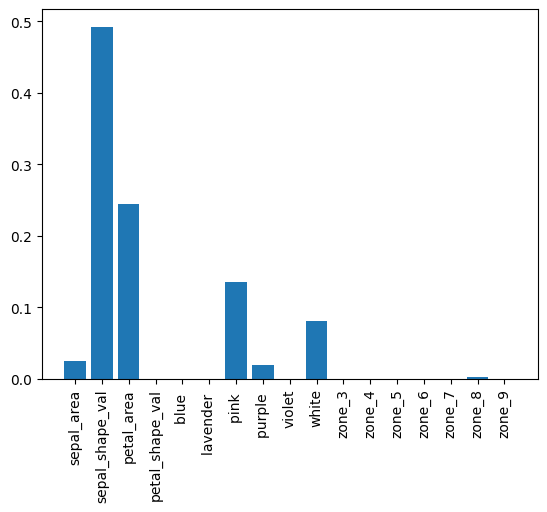

In [170]:
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Instantiate a baseline decision tree model
model = DecisionTreeClassifier()

# Fit the model using the full dataset (abnormal; since we only have 149 records)
model.fit(df_feat_imp.iloc[:,1:], df_feat_imp.species)

# Retrieve the feature importance coefficients from the trained model
fi_coefs = model.feature_importances_

# # Print the model's confusion matrix
# confusion_matrix(df_feat_imp.species, model.predict(df_feat_imp.iloc[:,1:]))

# # Print the feature importance coefficients
# for i,v in enumerate(fi_coefs):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

# Visualize the feature importance coefficients
plt.bar(df_feat_imp.columns[1:], fi_coefs)
plt.xticks(rotation=90)
plt.show()